# Single-Track Event Analysis

This notebook identifies and analyzes events with exactly one reconstructed track for high-quality particle identification. The workflow includes:

- **Data Merging**: Combines track reconstruction data with proton mass preselection
- **Quality Filter**: Selects events with `ntracks_reco == 1` for clean analysis
- **Event Display**: Links single-track events to raw detector data for visualization
- **Batch Processing**: Generates collection plane heatmaps for all matched events

Single-track events provide the cleanest sample for proton-deuteron separation studies by eliminating reconstruction ambiguities from multi-particle interactions.

Uses RAW data from LArIAT and data created using .ROOT analysis file to find one track events using LArIAT reconstruction.

In [1]:
import pandas as pd

In [2]:
TRACK_COUNT_DATA_PATH = "/Users/user/data/research/proton-deuteron/csv/trackcount.csv"
PROTON_PRESELECTION = "/Users/user/data/research/proton-deuteron/csv/preprotons_pm_600_1600.csv"
RAW_FILES = "/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root"

In [3]:
trackdf = pd.read_csv(TRACK_COUNT_DATA_PATH)
protondf = pd.read_csv(PROTON_PRESELECTION)

In [4]:
trackdf, trackdf.columns

(         run  subrun  event  ntracks_reco
 0       8675      12   1249             1
 1       8675      12   1250            23
 2       8675      12   1256             2
 3       8675      12   1257             2
 4       8675      12   1258             3
 ...      ...     ...    ...           ...
 580633  9781     133  21593             0
 580634  9781     133  21596             2
 580635  9781     133  21614             4
 580636  9781     133  21621             2
 580637  9781     133  21623             7
 
 [580638 rows x 4 columns],
 Index(['run', 'subrun', 'event', 'ntracks_reco'], dtype='object'))

In [5]:
protondf, protondf.columns

(        run  subrun  event
 0      8675      38   4220
 1      8675      40   4514
 2      8675      54   5807
 3      8675      54   5821
 4      8675      54   5843
 ...     ...     ...    ...
 16930  9781     109  17974
 16931  9781     111  18262
 16932  9781     112  18441
 16933  9781     124  20209
 16934  9781     127  20677
 
 [16935 rows x 3 columns],
 Index(['run', 'subrun', 'event'], dtype='object'))

In [6]:
protontrackdf = trackdf.merge(
    protondf[['run', 'subrun', 'event']],
    on=['run', 'subrun', 'event'],
    how='inner'
)

In [7]:
protontrackdf

,run,subrun,event,ntracks_reco
0,8675,38,4220,2
1,8675,40,4514,6
2,8675,54,5807,1
3,8675,54,5821,1
4,8675,54,5843,2
...,...,...,...,...
16930,9781,109,17974,1
16931,9781,111,18262,2
16932,9781,112,18441,1
16933,9781,124,20209,1


In [8]:
onetrackprotonsdf = protontrackdf[(protontrackdf['ntracks_reco'] == 1)]

In [9]:
onetrackprotonsdf

,run,subrun,event,ntracks_reco
2,8675,54,5807,1
3,8675,54,5821,1
5,8675,54,5844,1
8,8675,68,7061,1
10,8675,88,9222,1
...,...,...,...,...
16927,9781,103,16997,1
16928,9781,109,17945,1
16930,9781,109,17974,1
16932,9781,112,18441,1


In [11]:
manyprotonsdf = protontrackdf[(protontrackdf['ntracks_reco'] != 1)]
manyprotonsdf

,run,subrun,event,ntracks_reco
0,8675,38,4220,2
1,8675,40,4514,6
4,8675,54,5843,2
6,8675,66,6914,0
7,8675,68,7056,6
...,...,...,...,...
16924,9781,89,14857,0
16925,9781,89,14858,0
16929,9781,109,17951,0
16931,9781,111,18262,2


In [32]:
# onetrackdf.drop("ntracks_reco", axis=1).to_csv("/Users/user/data/research/proton-deuteron/csv/onetrackprotons.csv", index=False)

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from pathlib import Path

class EventSearchViewer():
    """
    Event viewer that searches through ROOT files by opening them
    and checking the ana/raw tree for matching events, with beamline mass info
    """
    def __init__(self, onetrackdf, root_files_dir):
        self.onetrackdf = onetrackdf # .csv with run, subrun, event with only 1 track
        self.root_files_dir = Path(root_files_dir) # path where the RAW .root files are
        self.matched_events = self._search_matching_events() # events with 1 track
        
    def _search_matching_events(self):
        """Search all ROOT files for events that match onetrackdf"""
        print("Searching ROOT files for matching events...")
        
        matched = []
        
        # Target events from onetrackdf
        target_events = set()
        for idx, row in self.onetrackdf.iterrows():
            trun = int(row['run'])
            tsubrun = int(row['subrun'])
            tevent = int(row['event'])
            target_events.add((trun, tsubrun, tevent))
        
        # Search through all ROOT files
        root_files = list(self.root_files_dir.glob("*.root"))
        print(f"Found {len(root_files)} ROOT files to search")
        
        for i, root_file in enumerate(root_files): 
            
            if i % 10 == 0: # progress bar every 10 files 
                print(f"Searching file {i+1}/{len(root_files)}: {root_file.name}")
            
            try:
                with uproot.open(root_file) as file:                # Check if ana/raw tree exists, opening files one by one
                    if "ana/raw" not in file:
                        continue
                
                tree = file["ana/raw"]
                
                # Get all events in this file
                try:
                    events_data = tree.arrays(["run", "subrun", "event"], library="pd") 
                    
                    # Check each event in this file
                    for event_idx, event_row in events_data.iterrows():
                        erun = int(event_row['run'])
                        esubrun = int(event_row['subrun'])
                        eevent = int(event_row['event'])
                        
                        # Check if this event is in our target list
                        if (erun, esubrun, eevent) in target_events:
                            
                            matched.append({
                                'run': erun,
                                'subrun': esubrun,
                                'event': eevent,
                                'file_path': str(root_file),
                                'filename': root_file.name,
                                'event_index_in_file': event_idx,
                            })
                            print(f"  ✓ Found match: Run {erun}, Subrun {esubrun}, Event {eevent}")
                
                except Exception as e:
                    print(f"  Error reading events from {root_file.name}: {e}")
                    continue
                        
            except Exception as e:
                print(f"  Error opening {root_file.name}: {e}")
                continue
        
        print(f"\nSearch complete! Found {len(matched)} matching events")
        return matched
    
    def show_event(self, match_index=0):
        """Show collection plane for specific matched event"""
        if match_index >= len(self.matched_events):
            print(f"Match index {match_index} out of range (max: {len(self.matched_events)-1})")
            return
            
        event_info = self.matched_events[match_index]
        
        try:
            # Load ROOT file
            with uproot.open(event_info['file_path']) as root_file:
                tree = root_file["ana/raw"]
                
                # Data for the specific event
                branches_to_load = ["run", "subrun", "event", "raw_rawadc", "raw_channel"]
                
                # Load specific event by index
                event_start = event_info['event_index_in_file']
                event_data = tree.arrays(branches_to_load, library="pd", 
                                    entry_start=event_start, entry_stop=event_start+1)
                
                if event_data.empty:
                    print("No data found for this event")
                    return

                # Process the data
                first_event = event_data.iloc[0]
                adc_data = ak.to_numpy(first_event["raw_rawadc"])
                channel_map = ak.to_numpy(first_event["raw_channel"])
                
                # Reshape ADC data
                total_wires = 480
                num_ticks = adc_data.size // total_wires
                adc_data_2d = adc_data.reshape((total_wires, num_ticks))
                
                # Create collection plane (channels 240-479)
                collection_plane = np.zeros((240, num_ticks))
                
                for i, channel_num in enumerate(channel_map):
                    if 240 <= channel_num < 480:
                        wire_index = channel_num - 240
                        collection_plane[wire_index, :] = adc_data_2d[i, :]
                
                # Plot heatmap
                plt.figure(figsize=(12, 6))
                sns.heatmap(collection_plane.T, cmap="viridis")
                plt.gca().invert_yaxis()
                plt.xlabel("Wire (0-239)")
                plt.ylabel("Tick")
                
                title = f"Collection Plane - Run {event_info['run']}, Subrun {event_info['subrun']}, Event {event_info['event']}"
                plt.title(title)
                plt.show()
                
                print(f"Showing match {match_index}/{len(self.matched_events)-1}")
                
        except Exception as e:
            print(f"Error loading event: {e}")
    
    def list_matches(self):
        """List all matched events"""
        print("Matched events found:")
        for i, event in enumerate(self.matched_events):
            print(f"{i}: Run {event['run']}, Subrun {event['subrun']}, Event {event['event']} (from {event['filename']})")
        print(f"\nTotal: {len(self.matched_events)} matches")

In [ ]:
# Viewer (search all ROOT files)
viewer = EventSearchViewer(onetrackprotonsdf, "/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root")

Searching ROOT files for matching events...
Found 12531 ROOT files to search
Searching file 1/12531: extracted_lariat_digit_r008678_sr0247_20160529T084850_evtsel_1.root
  ✓ Found match: Run 8678, Subrun 247, Event 11727
  ✓ Found match: Run 9541, Subrun 40, Event 3023
  ✓ Found match: Run 8596, Subrun 410, Event 37719
  ✓ Found match: Run 8738, Subrun 336, Event 33972
  ✓ Found match: Run 8595, Subrun 52, Event 4933
  ✓ Found match: Run 8605, Subrun 447, Event 40187
  ✓ Found match: Run 8605, Subrun 447, Event 40190
Searching file 11/12531: extracted_lariat_digit_r008652_sr0030_20160527T090523_evtsel_1.root
  ✓ Found match: Run 8652, Subrun 30, Event 2440
  ✓ Found match: Run 9449, Subrun 10, Event 821
  ✓ Found match: Run 9473, Subrun 300, Event 25888
  ✓ Found match: Run 8681, Subrun 313, Event 25913
  ✓ Found match: Run 9447, Subrun 373, Event 33208
  ✓ Found match: Run 8595, Subrun 108, Event 10002
  ✓ Found match: Run 9542, Subrun 114, Event 7864
  ✓ Found match: Run 8689, Subrun 

In [203]:
# List all matches
viewer.list_matches()

Matched events found:
0: Run 8678, Subrun 247, Event 11727 (from extracted_lariat_digit_r008678_sr0247_20160529T084850_evtsel_1.root)
1: Run 9541, Subrun 40, Event 3023 (from extracted_lariat_digit_r009541_sr0040_20160619T054506_evtsel_1.root)
2: Run 8596, Subrun 410, Event 37719 (from extracted_lariat_digit_r008596_sr0410_20160529T150357_evtsel_1.root)
3: Run 8738, Subrun 336, Event 33972 (from extracted_lariat_digit_r008738_sr0336_20160530T121512_evtsel_1.root)
4: Run 8595, Subrun 52, Event 4933 (from extracted_lariat_digit_r008595_sr0052_20160604T191011_evtsel_1.root)
5: Run 8605, Subrun 447, Event 40187 (from extracted_lariat_digit_r008605_sr0447_20160605T011123_evtsel_1.root)
6: Run 8605, Subrun 447, Event 40190 (from extracted_lariat_digit_r008605_sr0447_20160605T011123_evtsel_1.root)
7: Run 8652, Subrun 30, Event 2440 (from extracted_lariat_digit_r008652_sr0030_20160527T090523_evtsel_1.root)
8: Run 9449, Subrun 10, Event 821 (from extracted_lariat_digit_r009449_sr0010_20160610T0

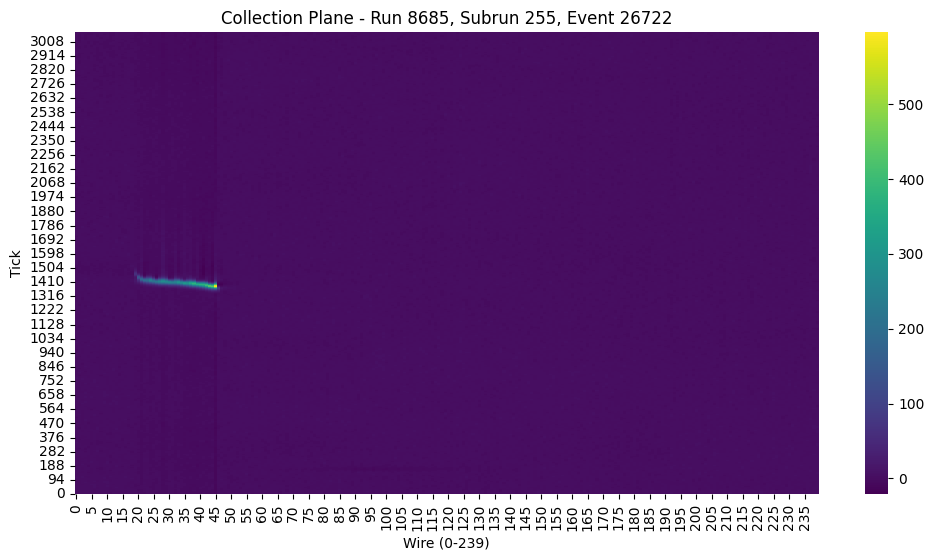

Error loading event: name 'run' is not defined


In [210]:
# Show specific events
viewer.show_event(7635)

In [13]:
# Faster - changed by Claude

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

# This helper function should remain in its own file (e.g., search_worker.py)
from search_worker import process_single_file

class EventSearchViewer():
    """
    An optimized event viewer that uses parallel processing to quickly
    search through ROOT files for specified events, or process all events in a directory.
    """
    def __init__(self, onetrackdf=None, root_files_dir=None):
        self.onetrackdf = onetrackdf
        self.root_files_dir = Path(root_files_dir) if root_files_dir else None
        self.matched_events = []
        self.process_all_mode = onetrackdf is None

    def search_files(self, max_workers=None):
        """
        Search all ROOT files in parallel for events that match onetrackdf.
        """
        if self.process_all_mode:
            return self._process_all_events_sequential()
        
        print("Optimizing target event list...")
        target_events_set = set(zip(
            self.onetrackdf['run'].astype(int),
            self.onetrackdf['subrun'].astype(int),
            self.onetrackdf['event'].astype(int)
        ))

        root_files = list(self.root_files_dir.glob("*.root"))
        print(f"Found {len(root_files)} ROOT files. Starting parallel search...")

        matched = []
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(process_single_file, path, target_events_set) for path in root_files]
            
            for future in tqdm(as_completed(futures), total=len(root_files), desc="Searching Files"):
                result = future.result()
                if result:
                    matched.extend(result)
        
        print(f"\nSearch complete! Found {len(matched)} matching events.")
        self.matched_events = sorted(matched, key=lambda x: (x['run'], x['subrun'], x['event']))
        return self.matched_events

    def _process_all_events_sequential(self):
        """
        Process all events in all ROOT files in the directory sequentially.
        This avoids the multiprocessing issues with notebook-defined functions.
        """
        root_files = list(self.root_files_dir.glob("*.root"))
        print(f"Found {len(root_files)} ROOT files. Processing all events...")

        all_events = []
        for file_path in tqdm(root_files, desc="Processing Files"):
            try:
                with uproot.open(file_path) as root_file:
                    if "ana/raw" not in root_file:
                        continue
                    
                    tree = root_file["ana/raw"]
                    events_data = tree.arrays(["run", "subrun", "event"], library="pd")
                    
                    for event_idx, event_row in events_data.iterrows():
                        all_events.append({
                            'run': int(event_row['run']),
                            'subrun': int(event_row['subrun']),
                            'event': int(event_row['event']),
                            'file_path': str(file_path),
                            'filename': file_path.name,
                            'event_index_in_file': event_idx,
                        })
            except Exception as e:
                print(f"Error processing {file_path.name}: {e}")
                continue
        
        print(f"\nProcessing complete! Found {len(all_events)} total events.")
        self.matched_events = sorted(all_events, key=lambda x: (x['run'], x['subrun'], x['event']))
        return self.matched_events

    def _get_event_image_data(self, match_index):
        """
        Internal helper to fetch and process data for plotting using the correct
        physical mapping of channels to a fixed canvas.
        """
        if not (0 <= match_index < len(self.matched_events)):
            print(f"Match index {match_index} out of range.")
            return None, None

        event_info = self.matched_events[match_index]
        try:
            with uproot.open(event_info['file_path']) as root_file:
                tree = root_file["ana/raw"]
                event_start = event_info['event_index_in_file']
                event_data = tree.arrays(
                    ["raw_rawadc", "raw_channel"],
                    entry_start=event_start, entry_stop=event_start + 1, library="ak"
                )
                
                if len(event_data) == 0:
                    print(f"Warning: No data found in file for event at index {match_index}.")
                    return None, None

                # Use ak.to_numpy for explicit conversion
                adc_data = ak.to_numpy(event_data["raw_rawadc"][0])
                channel_map = ak.to_numpy(event_data["raw_channel"][0])
                
                # Reshape based on the total number of channels present in the data
                num_channels_in_event = len(channel_map)
                if num_channels_in_event == 0:
                    print(f"Warning: Event at index {match_index} has no channel data.")
                    return None, None
                
                num_ticks = len(adc_data) // num_channels_in_event
                adc_data_2d = adc_data.reshape((num_channels_in_event, num_ticks))

                # Create a fixed-size canvas for the collection plane (240 wires)
                collection_plane = np.zeros((240, num_ticks))

                # Populate the canvas at the correct physical wire location
                for i, channel_num in enumerate(channel_map):
                    if 240 <= channel_num < 480:
                        wire_index = channel_num - 240 # Map channel 240 to index 0
                        collection_plane[wire_index, :] = adc_data_2d[i, :]
                
                title = f"Collection Plane - Run {event_info['run']}, Subrun {event_info['subrun']}, Event {event_info['event']}"
                
                # Transpose for plotting (Time vs. Wire)
                return collection_plane.T, title
                
        except Exception as e:
            print(f"Error processing data for event at index {match_index}: {e}")
            return None, None

    def show_event(self, match_index=0):
        """Shows the collection plane event display for a specific matched event."""
        image_data, title = self._get_event_image_data(match_index)
        
        if image_data is None:
            print(f"Could not generate plot for event at index {match_index}.")
            return
        
        print(f"Displaying: {title}")
        plt.figure(figsize=(10, 5))
        sns.heatmap(image_data, cmap="viridis", cbar_kws={'label': 'ADC Counts'})
        plt.title(title)
        # Correctly label the axes
        plt.xlabel("Collection Plane Wire Number (0-239)")
        plt.ylabel("Time Tick")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    def save_all_images(self, output_dir=None):
        """
        Generates and saves a PNG image for every matched event.
        """
        if not self.matched_events:
            print("No events found. Run .search_files() first.")
            return
        
        # Use directory name if no output_dir specified and in process_all_mode
        if output_dir is None:
            if self.process_all_mode and self.root_files_dir:
                output_dir = f"{self.root_files_dir.name}_event_images"
            else:
                output_dir = "event_images"
            
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        print(f"Saving {len(self.matched_events)} images to '{output_path.resolve()}'...")

        for i, event_info in enumerate(tqdm(self.matched_events, desc="Saving Images")):
            image_data, title = self._get_event_image_data(i)
            
            if image_data is None:
                continue

            filename = f"run_{event_info['run']}_subrun_{event_info['subrun']}_event_{event_info['event']}.png"
            full_path = output_path / filename

            if full_path.exists():
                continue  # Skip if already saved

            plt.figure(figsize=(10, 5))
            sns.heatmap(image_data, cmap="viridis", cbar_kws={'label': 'ADC Counts'})
            plt.title(title)
            # Correctly label the axes
            plt.xlabel("Collection Plane Wire Number (0-239)")
            plt.ylabel("Time Tick")
            plt.gca().invert_yaxis()
            plt.tight_layout()
            
            plt.savefig(full_path, dpi=90, bbox_inches='tight')
            plt.close()

        print("\nFinished saving all images.")

    def list_matches(self):
        """List all matched events"""
        if not self.matched_events:
            print("No events found. Run .search_files() first.")
            return

        event_type = "events" if self.process_all_mode else "matched events"
        print(f"\n{event_type.title()} found:")
        for i, event in enumerate(self.matched_events):
            print(f"{i}: Run {event['run']}, Subrun {event['subrun']}, Event {event['event']} (from {event['filename']})")
        print(f"\nTotal: {len(self.matched_events)} {event_type}")

    @classmethod
    def process_directory(cls, root_files_dir):
        """
        Convenience method to process all events in a directory without matching.
        """
        viewer = cls(onetrackdf=None, root_files_dir=root_files_dir)
        return viewer

## New Usage Modes

The `EventSearchViewer` now supports two modes:

1. **Matching Mode** (original): Pass both `onetrackdf` and `root_files_dir` to find specific events
2. **Process All Mode** (new): Pass only `root_files_dir` to process all events in the directory

### Example Usage for Process All Mode:

```python
# Process all events in a directory
viewer = EventSearchViewer.process_directory("/path/to/root/files")
viewer.search_files()  # This will process all events
viewer.save_all_images()  # Images saved to "{directory_name}_event_images"
```

The output directory will be automatically named based on the input directory name.

In [7]:
# Example: Process all events in a directory without matching
# viewer_all = EventSearchViewer.process_directory("/Users/user/data/research/proton-deuteron/rawprotons/proton_extracted_root")
# viewer_all.search_files()
# viewer_all.save_all_images()  # Will create "proton_extracted_root_event_images" directory

# Or with explicit parameters:
# viewer_all = EventSearchViewer(onetrackdf=None, root_files_dir="/path/to/root/files")
# viewer_all.search_files()
# viewer_all.save_all_images("custom_output_directory")

In [14]:
viewer = EventSearchViewer.process_directory("/Users/user/data/research/proton-deuteron/rawdeuterons/deuteron_extracted_root")

In [15]:
viewer.search_files()

Found 8289 ROOT files. Processing all events...


Processing Files: 100%|██████████| 8289/8289 [00:38<00:00, 215.89it/s]


Processing complete! Found 9852 total events.


[{'run': 8557,
  'subrun': 4,
  'event': 473,
  'file_path': '/Users/user/data/research/proton-deuteron/rawdeuterons/deuteron_extracted_root/extracted_lariat_digit_r008557_sr0004_20160529T072435_evtsel_1.root',
  'filename': 'extracted_lariat_digit_r008557_sr0004_20160529T072435_evtsel_1.root',
  'event_index_in_file': 0},
 {'run': 8557,
  'subrun': 8,
  'event': 653,
  'file_path': '/Users/user/data/research/proton-deuteron/rawdeuterons/deuteron_extracted_root/extracted_lariat_digit_r008557_sr0008_20160529T072623_evtsel_1.root',
  'filename': 'extracted_lariat_digit_r008557_sr0008_20160529T072623_evtsel_1.root',
  'event_index_in_file': 0},
 {'run': 8557,
  'subrun': 17,
  'event': 1052,
  'file_path': '/Users/user/data/research/proton-deuteron/rawdeuterons/deuteron_extracted_root/extracted_lariat_digit_r008557_sr0017_20160529T073018_evtsel_1.root',
  'filename': 'extracted_lariat_digit_r008557_sr0017_20160529T073018_evtsel_1.root',
  'event_index_in_file': 0},
 {'run': 8557,
  'subru

In [16]:
if viewer.matched_events:
    print(f"Total events found: {len(viewer.matched_events)}")
    print("Testing with first 10 events...")
    
    # Temporarily save only first 10 events for testing
    original_events = viewer.matched_events
    viewer.matched_events = viewer.matched_events[:10]
    
    # This will create "deuteron_extracted_root_event_images" directory automatically
    viewer.save_all_images()
    
    # Restore full event list
    viewer.matched_events = original_events

Saving 9852 images to '/Users/user/code/research/proton-deuteron/notebooks/event_images'...


Saving Images:  30%|██▉       | 2908/9852 [23:48<53:41,  2.16it/s]   

: 

Displaying: Collection Plane - Run 8590, Subrun 17, Event 1686


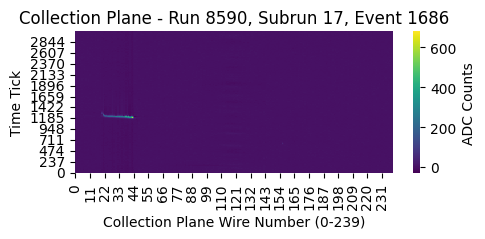

In [240]:
if viewer.matched_events:
    viewer.show_event(565)

In [ ]:
# Faster - changed by Claude

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

# This helper function should remain in its own file (e.g., search_worker.py)
from search_worker import process_single_file

class EventSearchViewer():
    """
    An optimized event viewer that uses parallel processing to quickly
    search through ROOT files for specified events.
    """
    def __init__(self, onetrackdf, root_files_dir):
        self.onetrackdf = onetrackdf
        self.root_files_dir = Path(root_files_dir)
        self.matched_events = []

    def search_files(self, max_workers=None):
        """
        Search all ROOT files in parallel for events that match onetrackdf.
        """
        print("Optimizing target event list...")
        target_events_set = set(zip(
            self.onetrackdf['run'].astype(int),
            self.onetrackdf['subrun'].astype(int),
            self.onetrackdf['event'].astype(int)
        ))

        root_files = list(self.root_files_dir.glob("*.root"))
        print(f"Found {len(root_files)} ROOT files. Starting parallel search...")

        matched = []
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(process_single_file, path, target_events_set) for path in root_files]
            
            for future in tqdm(as_completed(futures), total=len(root_files), desc="Searching Files"):
                result = future.result()
                if result:
                    matched.extend(result)
        
        print(f"\nSearch complete! Found {len(matched)} matching events.")
        self.matched_events = sorted(matched, key=lambda x: (x['run'], x['subrun'], x['event']))
        return self.matched_events

    def _get_event_image_data(self, match_index):
        """
        Internal helper to fetch and process data for plotting using the correct
        physical mapping of channels to a fixed canvas.
        """
        if not (0 <= match_index < len(self.matched_events)):
            print(f"Match index {match_index} out of range.")
            return None, None

        event_info = self.matched_events[match_index]
        try:
            with uproot.open(event_info['file_path']) as root_file:
                tree = root_file["ana/raw"]
                event_start = event_info['event_index_in_file']
                event_data = tree.arrays(
                    ["raw_rawadc", "raw_channel"],
                    entry_start=event_start, entry_stop=event_start + 1, library="ak"
                )
                
                if len(event_data) == 0:
                    print(f"Warning: No data found in file for event at index {match_index}.")
                    return None, None

                # Use ak.to_numpy for explicit conversion
                adc_data = ak.to_numpy(event_data["raw_rawadc"][0])
                channel_map = ak.to_numpy(event_data["raw_channel"][0])
                
                # Reshape based on the total number of channels present in the data
                num_channels_in_event = len(channel_map)
                if num_channels_in_event == 0:
                    print(f"Warning: Event at index {match_index} has no channel data.")
                    return None, None
                
                num_ticks = len(adc_data) // num_channels_in_event
                adc_data_2d = adc_data.reshape((num_channels_in_event, num_ticks))

                # Create a fixed-size canvas for the collection plane (240 wires)
                collection_plane = np.zeros((240, num_ticks))

                # Populate the canvas at the correct physical wire location
                for i, channel_num in enumerate(channel_map):
                    if 240 <= channel_num < 480:
                        wire_index = channel_num - 240 # Map channel 240 to index 0
                        collection_plane[wire_index, :] = adc_data_2d[i, :]
                
                title = f"Collection Plane - Run {event_info['run']}, Subrun {event_info['subrun']}, Event {event_info['event']}"
                
                # Transpose for plotting (Time vs. Wire)
                return collection_plane.T, title
                
        except Exception as e:
            print(f"Error processing data for event at index {match_index}: {e}")
            return None, None

    def show_event(self, match_index=0):
        """Shows the collection plane event display for a specific matched event."""
        image_data, title = self._get_event_image_data(match_index)
        
        if image_data is None:
            print(f"Could not generate plot for event at index {match_index}.")
            return
        
        print(f"Displaying: {title}")
        plt.figure(figsize=(10, 5))
        sns.heatmap(image_data, cmap="viridis", cbar_kws={'label': 'ADC Counts'})
        plt.title(title)
        # Correctly label the axes
        plt.xlabel("Collection Plane Wire Number (0-239)")
        plt.ylabel("Time Tick")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

    def save_all_images(self, output_dir="event_images"):
        """
        Generates and saves a PNG image for every matched event.
        """
        if not self.matched_events:
            print("No matches found. Run .search_files() first.")
            return
            
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        print(f"Saving {len(self.matched_events)} images to '{output_path.resolve()}'...")

        for i, event_info in enumerate(tqdm(self.matched_events, desc="Saving Images")):
            image_data, title = self._get_event_image_data(i)
            
            if image_data is None:
                continue

            filename = f"run_{event_info['run']}_subrun_{event_info['subrun']}_event_{event_info['event']}.png"
            full_path = output_path / filename

            if full_path.exists():
                continue  # Skip if already saved


            plt.figure(figsize=(10, 5))
            sns.heatmap(image_data, cmap="viridis", cbar_kws={'label': 'ADC Counts'})
            plt.title(title)
            # Correctly label the axes
            plt.xlabel("Collection Plane Wire Number (0-239)")
            plt.ylabel("Time Tick")
            plt.gca().invert_yaxis()
            plt.tight_layout()
            
            plt.savefig(full_path, dpi=90, bbox_inches='tight')
            plt.close()

        print("\nFinished saving all images.")

    def list_matches(self):
        """List all matched events"""
        if not self.matched_events:
            print("No matches found. Run .search_files() first.")
            return

        print("\nMatched events found:")
        for i, event in enumerate(self.matched_events):
            print(f"{i}: Run {event['run']}, Subrun {event['subrun']}, Event {event['event']} (from {event['filename']})")
        print(f"\nTotal: {len(self.matched_events)} matches")